In [139]:
import numpy as np

In [140]:
# 特征0：0：青年，1：中年，2：老年
# 特征1：0：无工作，1：有工作
# 特征2：0：无房产，1：有房产
# 特征3：0：信贷一般，1：信贷好，2：信贷非常好
X = np.array([[0,0,0,0],
              [0,0,0,1],
              [0,1,0,1],
              [0,1,1,0],
              [0,0,0,0],
              [1,0,0,0],
              [1,0,0,1],
              [1,1,1,1],
              [1,0,1,2],
              [1,0,1,2],
              [2,0,1,2],
              [2,0,1,1],
              [2,1,0,1],
              [2,1,0,2],
              [2,0,0,0]])
# 标签：0：不贷款，1：贷款
y = np.array([0,0,1,1,0,0,0,1,1,1,1,1,1,1,0])

In [141]:
def multi(y):
    ySet = set(y)
    bestCount = 0
    for yi in ySet:
        count = list(y).count(yi)
        if count > bestCount:
            bestCount = count
            bestyi = yi
    return bestyi

In [142]:
def gini(y):
    ySet = set(y)
    ret, n = 1, y.shape[0]
    for yi in ySet:
        ret -= (y[y==yi].shape[0]/n)**2
    return ret

def CART(X, y):
    # 若D中所有实例属于同一类$$C_k$$
    if len(set(y))==1:
        # 将类$$C_k$$作为该结点的类标记
        return {'label':y[0], 'gini':0,'Tt':1,'y':y.copy(),'cost':0}
    bestGini = np.inf
    # 对每个特征feature的每个取值value
    for feature in range(X.shape[1]):
        for value in set(X[:,feature]):
            # 将X分为$$R_1$$和$$R_2$$两个集合
            y1 = y[X[:,feature]<= value]
            y2 = y[X[:,feature]> value]
            # 计算$$R_1$$和$$R_2$$的基尼指数之和
            sumGini = y1.shape[0]/y.shape[0]*gini(y1) + y2.shape[0]/y.shape[0]*gini(y2)
            # 选择基尼指数计算结果最小的(feature, value)作为当前的最优划分
            if sumGini < bestGini:
                bestFeature, bestValue, bestGini = feature, value, sumGini
    # 基于最优划分生成2个子结点，将数据分配到两个子结点中
    node = {'feature':bestFeature,
            'value':bestValue,
            'gini':gini(y),
            'y':y.copy(),
            'label':multi(y),
            'left':CART(X[X[:,bestFeature]<= bestValue], y[X[:,bestFeature]<= bestValue]),
           'right':CART(X[X[:,bestFeature]> bestValue], y[X[:,bestFeature]> bestValue])}
    node['Tt'] = node['left']['Tt'] + node['right']['Tt']
    node['cost'] = node['left']['Tt']/node['Tt']*node['left']['cost']
    + node['right']['Tt']/node['Tt']*node['right']['cost']
    return node
   

In [143]:
tree = CART(X, y)
tree

{'feature': 2,
 'value': 0,
 'gini': 0.48,
 'y': array([0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]),
 'label': 1,
 'left': {'feature': 1,
  'value': 0,
  'gini': 0.4444444444444445,
  'y': array([0, 0, 1, 0, 0, 0, 1, 1, 0]),
  'label': 0,
  'left': {'label': 0,
   'gini': 0,
   'Tt': 1,
   'y': array([0, 0, 0, 0, 0, 0]),
   'cost': 0},
  'right': {'label': 1, 'gini': 0, 'Tt': 1, 'y': array([1, 1, 1]), 'cost': 0},
  'Tt': 2,
  'cost': 0.0},
 'right': {'label': 1,
  'gini': 0,
  'Tt': 1,
  'y': array([1, 1, 1, 1, 1, 1]),
  'cost': 0},
 'Tt': 3,
 'cost': 0.0}

In [144]:
def isLeaf(Node):
    # return type(Node).__name__ != 'dict'
    return Node['Tt']==1
    
def calcAlphaList(Node):
    if isLeaf(Node):
        return
    costNotSplit = Node['gini']
    costSplit = Node['cost']
    alpha = (costNotSplit-costSplit)/(Node['Tt']-1)
    if (alpha<0):
        print (Node['Tt'], Node['gini'], Node['y'])
        print (Node['right']['Tt'], Node['right']['gini'], Node['left']['y'])
        print (Node['left']['Tt'], Node['left']['gini'], Node['right']['y'])
    Node['alpha'] = alpha
    if alpha < calcAlphaList.bestAlpha:
        calcAlphaList.bestAlpha = alpha
    calcAlphaList(Node['left'])
    calcAlphaList(Node['right'])
    
def calcTt(Node):
    if isLeaf(Node):
        return 1
    Node['Tt'] = calcTt(Node['left']) + calcTt(Node['right'])
    return Node['Tt']

def cut(Node, alpha):
    if isLeaf(Node):
        return
    if Node['alpha'] == alpha:
        Node.pop('left')
        Node.pop('right')
        Node.pop('feature')
        Node.pop('value')
        Node['cost'] = Node['gini']
        Node['Tt'] = 1
    else:
        cut(Node['left'], alpha)
        cut(Node['right'], alpha)
        
def prune(Tree):
    TreeList = [Tree.copy()]
    while not isLeaf(Tree):
        calcTt(Tree)  #每次剪过之后结点会变少，所以Tt要重新计算
        calcAlphaList.bestAlpha = np.inf
        calcAlphaList(Tree)
        print ('alpha',calcAlphaList.bestAlpha)
        cut(Tree, calcAlphaList.bestAlpha)
        TreeList.append(Tree.copy())
        return TreeList

In [145]:
tree = CART(X, y)
prune(tree)

alpha 0.24


[{'feature': 2,
  'value': 0,
  'gini': 0.48,
  'y': array([0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]),
  'label': 1,
  'left': {'feature': 1,
   'value': 0,
   'gini': 0.4444444444444445,
   'y': array([0, 0, 1, 0, 0, 0, 1, 1, 0]),
   'label': 0,
   'left': {'label': 0,
    'gini': 0,
    'Tt': 1,
    'y': array([0, 0, 0, 0, 0, 0]),
    'cost': 0},
   'right': {'label': 1, 'gini': 0, 'Tt': 1, 'y': array([1, 1, 1]), 'cost': 0},
   'Tt': 2,
   'cost': 0.0,
   'alpha': 0.4444444444444445},
  'right': {'label': 1,
   'gini': 0,
   'Tt': 1,
   'y': array([1, 1, 1, 1, 1, 1]),
   'cost': 0},
  'Tt': 3,
  'cost': 0.0},
 {'gini': 0.48,
  'y': array([0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]),
  'label': 1,
  'Tt': 1,
  'cost': 0.48,
  'alpha': 0.24}]

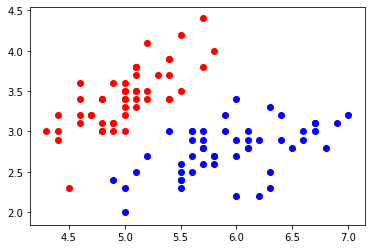

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

X = X[y<2,:2]
y = y[y<2]
plt.scatter(X[y==0,0],X[y==0,1], color='red')
plt.scatter(X[y==1,0],X[y==1,1], color='blue')
plt.show()

In [136]:
def predictOne(tree, xTest):
    if tree['Tt'] == 1:
        return tree['label']
    if xTest[tree['feature']] < tree['value']:
        return predictOne(tree['left'], xTest)
    else:
        return predictOne(tree['right'], xTest)
    
def predict(tree, X, y):
    yPredict = np.array([predictOne(tree, xTest) for xTest in X])
    return np.sum(yPredict!=y)/y.shape[0]

tree = CART(X, y)
TreeList = prune(tree)
print (len(TreeList))
bestError = np.inf
for tree in TreeList:
    error = predict(tree, X, y)
    if error < bestError:
        bestError = error
        bestTree = tree

bestTree

alpha 0.02172839506172842
2


{'feature': 0,
 'value': 5.4,
 'gini': 0.5,
 'y': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'label': 0,
 'left': {'feature': 1,
  'value': 2.7,
  'gini': 0.20761245674740492,
  'y': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 1, 1, 1, 1]),
  'label': 0,
  'left': {'feature': 0,
   'value': 4.5,
   'gini': 0.2777777777777777,
   'y': array([0, 1, 1, 1, 1, 1]),
   'label': 1,
   'left': {'label': 0, 'gini': 0, 'Tt': 1, 'y': array([0])},
   'right': {'label': 1, 'gini': 0, 'Tt': 1, 'y': array([1, 1, 1, 1, 1])},
   'Tt': 2,
   'alpha': 0.2777777777777777},
  'right': {'gini':